In [146]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
import re

Load the dataset 

In [147]:
df_spotify = pd.read_csv(r"C:\Users\ponnu\Downloads\ML_project\reviews.csv")
df_spotify.head()


,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


Removing the unneccessary columns

In [148]:

df_spotify = df_spotify[['Review', 'Rating']].dropna()

Check for Null Values

In [149]:
df_spotify.isnull().sum()

Review    0
Rating    0
dtype: int64

Labeling rating column

In [150]:
def label_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df_spotify['Rating'] = df_spotify['Rating'].apply(label_sentiment)


Distribution of rating

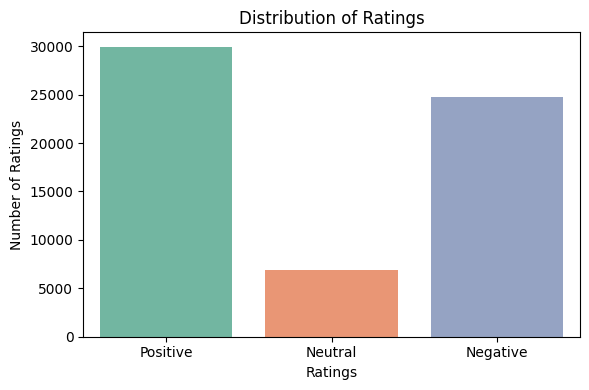

In [151]:

plt.figure(figsize=(6, 4))
sns.countplot(x='Rating', data=df_spotify, order=['Positive', 'Neutral', 'Negative'], palette='Set2')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Number of Ratings')
plt.tight_layout()
plt.show()


Tokenization

In [152]:
df_spotify['Review'] = [word_tokenize(review) for review in df_spotify['Review']]

In [153]:
print(df_spotify['Review'].iloc[0])

['Great', 'music', 'service', ',', 'the', 'audio', 'is', 'high', 'quality', 'and', 'the', 'app', 'is', 'easy', 'to', 'use', '.', 'Also', 'very', 'quick', 'and', 'friendly', 'support', '.']


Lemmatization and lowercasing

In [154]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df_spotify['Review'] = [
    [lemmatizer.lemmatize(word.lower()) for word in review] for review in df_spotify['Review']
]

Stopwords removal

In [155]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df_spotify['Review'] = [
    [word for word in review if word not in stop_words] for review in df_spotify['Review']
]


Hnadling hashtags

In [156]:
def remove_hashtags(tokens):
    return [word[1:] if word.startswith('#') else word for word in tokens]
df_spotify['Review'] = [
    remove_hashtags(review) for review in df_spotify['Review']
]


Handling emojis

In [157]:
import re
def remove_non_alphanumeric_tokens(tokens):
    return [token for token in tokens if token.isalnum()]
df_spotify['Review'] = [
    remove_non_alphanumeric_tokens(review) for review in df_spotify['Review']
]
print(df_spotify)


                                                  Review    Rating
0      [great, music, service, audio, high, quality, ...  Positive
1      [please, ignore, previous, negative, rating, a...  Positive
2      [get, best, spotify, experience, android, 12, ...  Positive
3               [really, buggy, terrible, use, recently]  Negative
4      [dear, spotify, get, song, put, playlist, shuf...  Negative
...                                                  ...       ...
61589  [even, though, wa, communicated, lyric, featur...  Negative
61590  [use, sooo, good, back, downloaded, free, vers...  Negative
61591  [app, would, good, taking, device, start, comp...  Negative
61592  [app, good, hard, navigate, wo, let, play, son...  Negative
61593  [good, sometimes, doesnt, load, music, play, l...  Positive

[61594 rows x 2 columns]


In [158]:
def remove_non_ascii_tokens(tokens):
    return [token for token in tokens if token.isascii()]
cleaned_reviews = []

for tokens in df_spotify['Review']:
    cleaned_tokens = remove_non_ascii_tokens(tokens)
    cleaned_reviews.append(cleaned_tokens)
df_spotify['Review'] = cleaned_reviews


Check for any emojis 

In [159]:
non_ascii_tokens = []
for tokens in df_spotify['Review']:
    for token in tokens:
        if not token.isascii():  # Check if token is non-ASCII
            non_ascii_tokens.append(token)

# Show total and unique tokens
print(f"Total non-ASCII tokens: {len(non_ascii_tokens)}")
print(f"Unique non-ASCII tokens: {len(set(non_ascii_tokens))}")
print("Some examples:", list(set(non_ascii_tokens))[:20])


Total non-ASCII tokens: 0
Unique non-ASCII tokens: 0
Some examples: []


Slang handling

In [160]:
# Basic slang dictionary
slang_dict = {
    "u": "you",
    "ur": "your",
    "lol": "laugh out loud",
    "brb": "be right back",
    "btw": "by the way",
    "idk": "I don't know",
    "omg": "oh my god",
    "tho": "though",
    "gonna": "going to",
    "wanna": "want to",
}
slang_tokens = []

for tokens in df_spotify['Review']:
    for token in tokens:
        if token.lower() in slang_dict:
            slang_tokens.append(token.lower())

# Show results
print(f"Total slang tokens found: {len(slang_tokens)}")
print(f"Unique slang tokens: {set(slang_tokens)}")


Total slang tokens found: 3358
Unique slang tokens: {'ur', 'idk', 'btw', 'omg', 'u', 'lol', 'tho'}


In [161]:
slang_words = {'ur', 'idk', 'btw', 'omg', 'u', 'lol', 'tho'}            # List of slang words

def remove_slang(tokens):                                               # Function to remove slang tokens
    return [token for token in tokens if token not in slang_words]
df_spotify['Review'] = [
    remove_slang(review) for review in df_spotify['Review']             # Remove slang words from the 'Review' column without using apply
]
df_spotify.head(10)


,Review,Rating
0,"[great, music, service, audio, high, quality, ...",Positive
1,"[please, ignore, previous, negative, rating, a...",Positive
2,"[get, best, spotify, experience, android, 12, ...",Positive
3,"[really, buggy, terrible, use, recently]",Negative
4,"[dear, spotify, get, song, put, playlist, shuf...",Negative
5,"[player, control, sometimes, disappear, reason...",Neutral
6,"[love, selection, lyric, provided, song, liste...",Positive
7,"[still, extremely, slow, changing, storage, ex...",Neutral
8,"[great, app, best, mp3, music, app, ever, used...",Positive
9,"[deleting, app, following, reason, app, ha, fa...",Negative


Handilng Numbers

In [172]:
# Function to remove tokens that contain both numbers
def remove_unwanted_tokens(tokens):
    clean_tokens = []
    for token in tokens:
        if any(char.isdigit() for char in token) and any(char.isalpha() for char in token):
            continue 
        clean_tokens.append(token)
    return clean_tokens
df_spotify['Review'] = [
    remove_unwanted_tokens(review) for review in df_spotify['Review']
]

# Show the cleaned reviews
print(df_spotify['Review'].head(10))


0    [great, music, service, audio, high, quality, ...
1    [please, ignore, previous, negative, rating, a...
2    [get, best, spotify, experience, android, anno...
3             [really, buggy, terrible, use, recently]
4    [dear, spotify, get, song, put, playlist, shuf...
5    [player, control, sometimes, disappear, reason...
6    [love, selection, lyric, provided, song, liste...
7    [still, extremely, slow, changing, storage, ex...
8    [great, app, best, music, app, ever, used, one...
9    [deleting, app, following, reason, app, ha, fa...
Name: Review, dtype: object
